# Imports

In [1]:
import pycuda.autoinit
import pycuda.driver as drv
from pycuda import gpuarray
from time import time
import numpy as np
import matplotlib.pyplot as plt
from pycuda.compiler import SourceModule
import pyaudio
import wave
from datetime import datetime
import ipywidgets as widgets
from IPython.display import clear_output
import sounddevice as sd
from scipy.io import wavfile
from math import ceil
from time import time

# Enviroment

In [2]:
gpu_device = drv.Device(0)
compute_capability = float("%d.%d" % gpu_device.compute_capability())
print("Capacidad: {}".format(compute_capability))
print("Memoria: {}".format(gpu_device.total_memory()))
print()
attr_GPU = gpu_device.get_attributes().items()
for k, v in attr_GPU:
    print("{}: {}".format(k, v))

Capacidad: 5.0
Memoria: 1031471104

ASYNC_ENGINE_COUNT: 1
CAN_MAP_HOST_MEMORY: 1
CLOCK_RATE: 860500
COMPUTE_CAPABILITY_MAJOR: 5
COMPUTE_CAPABILITY_MINOR: 0
COMPUTE_MODE: DEFAULT
CONCURRENT_KERNELS: 1
ECC_ENABLED: 0
GLOBAL_L1_CACHE_SUPPORTED: 0
GLOBAL_MEMORY_BUS_WIDTH: 64
GPU_OVERLAP: 1
INTEGRATED: 0
KERNEL_EXEC_TIMEOUT: 1
L2_CACHE_SIZE: 1048576
LOCAL_L1_CACHE_SUPPORTED: 1
MANAGED_MEMORY: 1
MAXIMUM_SURFACE1D_LAYERED_LAYERS: 2048
MAXIMUM_SURFACE1D_LAYERED_WIDTH: 16384
MAXIMUM_SURFACE1D_WIDTH: 16384
MAXIMUM_SURFACE2D_HEIGHT: 65536
MAXIMUM_SURFACE2D_LAYERED_HEIGHT: 16384
MAXIMUM_SURFACE2D_LAYERED_LAYERS: 2048
MAXIMUM_SURFACE2D_LAYERED_WIDTH: 16384
MAXIMUM_SURFACE2D_WIDTH: 65536
MAXIMUM_SURFACE3D_DEPTH: 4096
MAXIMUM_SURFACE3D_HEIGHT: 4096
MAXIMUM_SURFACE3D_WIDTH: 4096
MAXIMUM_SURFACECUBEMAP_LAYERED_LAYERS: 2046
MAXIMUM_SURFACECUBEMAP_LAYERED_WIDTH: 16384
MAXIMUM_SURFACECUBEMAP_WIDTH: 16384
MAXIMUM_TEXTURE1D_LAYERED_LAYERS: 2048
MAXIMUM_TEXTURE1D_LAYERED_WIDTH: 16384
MAXIMUM_TEXTURE1D_LINEAR

# Query-by-Humming: GPU Accelerated Melody Accurate Matching 

In [3]:
mod = SourceModule("""
 #define min(a,b) \
   ({ __typeof__ (a) _a = (a); \
       __typeof__ (b) _b = (b); \
     _a > _b ? _b : _a; })

__global__ void dtw_p(float *D, float *Q, float *P, int M, int stage){
    const int j = stage;
    const int i = threadIdx.x;
    // int idx = M*j+i;
    int tx = blockIdx.x*blockDim.x + threadIdx.x;
    if ((i >= 2 && blockIdx.x < 1 && tx < M) || (blockIdx.x > 0 && tx < M)) {
        int idx = M*stage + tx;
        int trie_1 = M*(stage - 1) + blockIdx.x*blockDim.x + threadIdx.x - 2;
        int trie_2 = M*(stage - 1) + blockIdx.x*blockDim.x + threadIdx.x - 1;
        int trie_3 = M*(stage - 2) + blockIdx.x*blockDim.x + threadIdx.x - 1;
        float cost = abs(P[j-1] - Q[i-1]);
        float minimun = min(D[trie_1], min(D[trie_2], D[trie_3]));
        D[idx] = cost + minimun;
    }
}
""")

dtw_p = mod.get_function("dtw_p")

In [4]:
def PDTW(Q, P):
    M = len(Q) + 1
    T = len(P) + 1
    D = np.empty((T, M), dtype = np.float32)
    D[0][0] = 0
    for i in range(1, M):
        if i > 1:
            D[1][i] = np.Inf
        D[0][i] = np.Inf
    for j in range(1, T):
        D[j][0] = np.Inf
        D[j][1] = abs(P[j-1]- Q[0])
    
    D_gpu = gpuarray.to_gpu(D)
    Q_gpu = gpuarray.to_gpu(Q)
    P_gpu = gpuarray.to_gpu(P)

    for j in range(2, T):
        dtw_p(D_gpu, Q_gpu, P_gpu, np.int32(M), np.int32(j), block=(min(M, 1024), 1, 1), grid=(ceil(M/1024),1))
    
    D = D_gpu.get()
    
    best = float("inf")
    for i in range(1, M):
        best = min(best, D[T-1][i])
        
    return best

In [5]:
def DTW(Q, P):
    M = len(Q) + 1
    T = len(P) + 1
    D = np.empty((T, M), dtype = np.float32)
    D[0][0] = 0
    for i in range(1, M):
        if i > 1:
            D[1][i] = np.Inf
        D[0][i] = np.Inf
    for j in range(1, T):
        D[j][0] = np.Inf
        D[j][1] = abs(P[j-1]- Q[0])

    for j in range(2, T):
        for i in range(2, M):
            D[j][i] = abs(P[j-1] - Q[i-1]) + min(D[j-1][i-2], D[j-1][i-1], D[j-2][i-1])
    
    best = float("inf")
    for i in range(1, M):
        best = min(best, D[T-1][i])
        
    return best

In [57]:
def PQBH(Q, dataset):
    melody_simily_list = []
    for song in dataset:
        P = song["P"]
        span = np.float32(10)
        smin = float("inf")
        smiddle = PDTW(Q, P)
        while span > 0.001:
            sleft = PDTW(Q, P - span)
            srigth = PDTW(Q, P + span)
            smin = min(sleft, smiddle, srigth)
            span /= 2
        melody_simily_list.append((song["song"], smin,))
    melody_simily_list.sort(key = lambda candiate: candiate[1])
    return melody_simily_list

In [56]:
def QBH(Q, dataset):
    melody_simily_list = []
    for song in dataset:
        P = song["P"]
        span = np.float32(10)
        smin = float("inf")
        smiddle = DTW(Q, P)
        while span > 0.001:
            sleft = DTW(Q, P - span)
            srigth = DTW(Q, P + span)
            smin = min(sleft, smiddle, srigth)
            span /= 2
        melody_simily_list.append((song["song"], smin,))
    melody_simily_list.sort(key = lambda candiate: candiate[1])
    return melody_simily_list

In [8]:
def get_pitch_secuence(filepath, chunk=2048):
    wf = wave.open(filepath)
    swidth = wf.getsampwidth()
    RATE = wf.getframerate()
    # open stream
    p = pyaudio.PyAudio()
    stream = p.open(format =
                    p.get_format_from_width(wf.getsampwidth()),
                    channels = wf.getnchannels(),
                    rate = RATE,
                    output = True)

    pitch_sequence = []

    # read some data
    data = wf.readframes(chunk)
    # play stream and find the frequency of each chunk
    while len(data) == chunk*swidth*wf.getnchannels():
        # write data out to the audio stream
        stream.write(data)
        # unpack the data and times
        indata = np.fromstring(data, dtype="int32")
        # Take the fft and square each value
        fftData = abs(np.fft.rfft(indata))**2
        # find the maximum
        which = fftData[1:].argmax() + 1
        # use quadratic interpolation around the max
        if which != len(fftData)-1:
            y0,y1,y2 = np.log(fftData[which-1:which+2:])
            x1 = (y2 - y0) * .5 / (2 * y1 - y2 - y0)
            # find the frequency and output it
            freq = (which+x1)*RATE/chunk
        else:
            freq = which*RATE/chunk
        if freq <= 0:
            semitone = 69
        else:
            semitone = 12*np.log2(freq/440) + 69
        pitch_sequence.append(semitone)
        # read some more data
        data = wf.readframes(chunk)
    if data:
        stream.write(data)
    stream.close()
    p.terminate()
    
    return np.array(pitch_sequence, dtype=np.float32)

# Load database

## Convert to pitch secuence

In [64]:
DATASET = []

SONGS_PATH = [
    "music/alanWalkerFaded_corte.wav",
    "music/badguy_corte.wav",
    "music/californication_corte.wav",
    "music/calvinHarrisBlame_corte.wav",
    "music/candyshopt_corte.wav",
    "music/dreamon_corte.wav",
    "music/hotelcalifornia_corte.wav",
    "music/loseYourself_corte.wav",
    "music/onemoretime_corte.wav",
    "music/paintblack_corte.wav",
    "music/satisfaction_corte.wav",
    "music/scartissue_corte.wav",
    "music/smokeonthewater_corte.wav",
    "music/theweeknd_corte.wav",
    "music/thunderstruck_corte.wav",
    "music/wildhorse_corte.wav",
    "music/wishyouwerehere_corte.wav",
    "music/withorwithoutyou_corte.wav"
]

for filepath in SONGS_PATH:
    DATASET.append({
        "P": get_pitch_secuence(filepath),
        "song": filepath[6:]
    })

/home/carlos/.local/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


## Save pitch secuences

In [66]:
with open("music/database.txt", "w+") as f:
    for song in DATASET:
        print(song["song"], len(song["P"]), file=f)
        for semitone in song["P"]:
            print(semitone, file=f)
    f.close()

## Load picth secuences

In [9]:
DATASET = []

f = open("music/database.txt", "r")
line = f.readline()
while line:
    song, length = line.strip().split()
    length = int(length)
    P = np.zeros(length, dtype=np.float32)
    for i in range(length):
        P[i] = np.float32(f.readline().strip())
    DATASET.append({
        "P": P,
        "song": song
    })
    line = f.readline()
f.close()

# Testing CPU vs GPU: Record Humming

In [10]:
times_CPU = []
times_GPU = []
speedups = []
n_songs = []

In [65]:
K = 18

In [71]:
record_button = widgets.Button(
    description="Record",
    disabled=False,
    button_style="danger",
    icon="microphone"
)
output = widgets.Output()

def recording(b):
    global times_CPU, times_GPU, speedups, n_songs
    with output:
        clear_output()
        record_time = time()
        record_button.disabled = True
        fs = 41500
        seconds = 5
        myrecord = sd.rec(
            int(seconds*fs),
            samplerate=fs,
            channels=2,
            dtype=np.int16
        )
        sd.wait()
        filepath = "hummings/hum_{}.wav".format(datetime.today().strftime("%d_%m_%Y_%X"))
        wavfile.write(filepath, fs, myrecord)
        Q = get_pitch_secuence(filepath)
        record_time =  time() - record_time
        
        time_g = time()
        print(PQBH(Q, DATASET))
        GPU_time = time() - time_g + record_time
        
        time_c = time()
        print(QBH(Q, DATASET[:K]))
        CPU_time = time() - time_c + record_time
        
        speedup = CPU_time/GPU_time
        
        print("Record time: {}".format(record_time))
        print("Speedup: {}".format(speedup))
        print("CPU time: {}".format(CPU_time))
        print("GPU time: {}".format(GPU_time))
        
        times_CPU.append(CPU_time)
        times_GPU.append(GPU_time)
        speedups.append(speedup)
        n_songs.append(K)
        
        record_button.disabled = False

record_button.on_click(recording)
display(widgets.HBox([record_button]))
display(output)

Output()

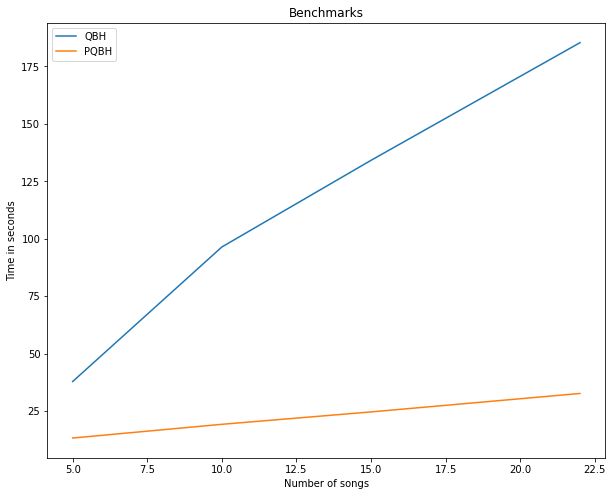

In [45]:
fig = plt.figure(figsize=[10, 8])
ax_c = plt.plot(n_songs, times_CPU, figure=fig, label="vandermonde_cpu")
ax_g = plt.plot(n_songs, times_GPU, figure=fig)
plt.title("Benchmarks", figure=fig)
plt.xlabel("Number of songs", figure=fig)
plt.ylabel("Time in seconds", figure=fig)
plt.legend(["QBH", "PQBH"])
plt.savefig("benchmarks.png", dpi=fig.dpi)

Text(0, 0.5, 'Speedup')

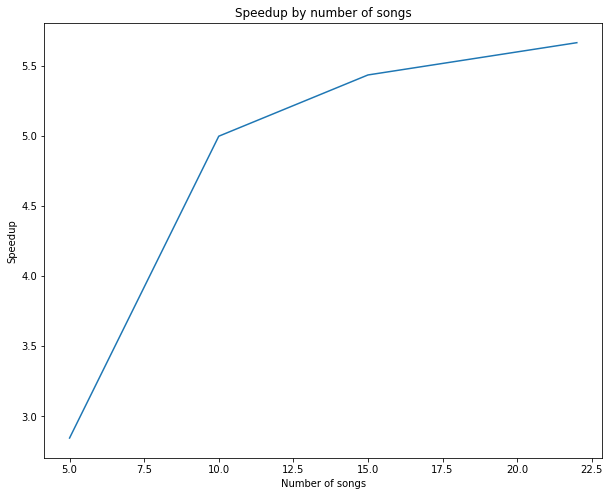

In [49]:
fig = plt.figure(figsize=[10, 8])
plt.plot(n_songs, speedups, figure=fig)
plt.title("Speedup by number of songs", figure=fig)
plt.xlabel("Number of songs", figure=fig)
plt.ylabel("Speedup", figure=fig)
plt.savefig("speedup.png", dpi=fig.dpi)